In [54]:
import numpy as np
import matplotlib.pyplot as plt

In [213]:
from tf_agents.agents import DdpgAgent,DqnAgent
from tf_agents.agents import ddpg,dqn
from tf_agents.utils import common
from tf_agents import networks
from tf_agents.environments import py_environment
from tf_agents.environments import tf_environment
from tf_agents.environments import tf_py_environment
from tf_agents.environments import utils
from tf_agents.specs import array_spec
from tf_agents.environments import wrappers
from tf_agents.environments import suite_gym
from tf_agents.trajectories import time_step as ts
from tf_agents.metrics import py_metrics
from tf_agents.drivers import py_driver,dynamic_episode_driver,dynamic_step_driver
from tf_agents.policies import random_py_policy,random_tf_policy,PyTFEagerPolicy
from tf_agents.replay_buffers import tf_uniform_replay_buffer,py_uniform_replay_buffer

from tensorflow import Tensor,Variable
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential


# PARAMETERS

In [198]:
nb_actions = 4
learning_rate_actor = 0.1
learning_rate_critic = 0.1

num_iterations = 1000
collect_steps_per_iteration = 10
replay_buffer_capacity = 1000

log_interval=100
eval_interval=1000

# Environment
## Version Python

In [199]:
class MyLogger:
    def __init__(self):
        self.logs = []
    def log(self,*args):
        self.logs.append(args)
    def reset(self):
        self.logs = []
    def __str__(self):
        return "\n".join(["\t".join(map(str,l)) for l in self.logs])

In [208]:
class IArchitectEnv(py_environment.PyEnvironment):
    def __init__(self,log=False):
        self._state = np.zeros((nb_actions,),dtype=np.int32)
#         self._action_spec = array_spec.BoundedArraySpec(
#             shape=(), dtype=np.float32, minimum=-0.49, maximum=3.49, name='action')
        self._action_spec = array_spec.BoundedArraySpec(
            shape=(), dtype=np.int32, minimum=0, maximum=3, name='action')
        self._observation_spec = array_spec.BoundedArraySpec(
            shape=(self._state.shape[0],), dtype=np.int32, minimum=0, name='observation')
        self._logger = MyLogger()
        
        self._episode_ended = False
        self.log = log
        self.REWARD = 10
        self.PENALTY_ALREADY_FILLED = -10
        self.DEFAULT_REWARD = 1

    def action_spec(self):
        return self._action_spec

    def observation_spec(self):
        return self._observation_spec

    def _reset(self):
        self._state = np.zeros((nb_actions,),dtype=np.int32)
        self._episode_ended = False
#         self._logger.reset()
        return ts.restart(self._state)
#         return ts.restart(np.array([self._state], dtype=np.int32))
    

    def _step(self, action):
        """
        Remplit la action_ième case
        Termine si action déjà remplie
        """
        if self._episode_ended:
            # The last action ended the episode. Ignore the current action and start
            # a new episode.
            return self.reset()

        # Make sure episodes don't go on forever.
        action_ = action.round().astype(int)
        assert action_ in list(range(self._state.shape[0]))
        if self.log:
            self._logger.log(self._state,action,action_)

        reward = self.DEFAULT_REWARD
        if self._state[action_]==1:
            reward = self.PENALTY_ALREADY_FILLED
            self._episode_ended = True

        self._state[action_]=1

        if self._state.sum()==self._state.shape[0]:
            self._episode_ended = True
            reward = self.REWARD
        
        if not self._episode_ended:
             result = ts.transition(
                self._state, reward=reward, discount=1)
#                 np.array([self._state], dtype=np.int32), reward=penalty, discount=0.95)
        
        else:
            result = ts.termination(self._state, reward)
#             return ts.termination(np.array([self._state], dtype=np.int32), reward)
        if self.log:
            self._logger.log(result.observation,reward)
        return result


In [209]:
environment = IArchitectEnv(log=True)
environment_eval = IArchitectEnv(log=True)
# environment = CardGameEnv()
utils.validate_py_environment(environment, episodes=5)
utils.validate_py_environment(environment_eval, episodes=5)

## Version TF

In [210]:
train_env = tf_py_environment.TFPyEnvironment(environment)
eval_env = tf_py_environment.TFPyEnvironment(environment_eval)

# Agents
## DDPG
### Networks

In [203]:
observation_spec, action_spec = train_env.observation_spec(), train_env.action_spec()
actor_net = ddpg.actor_network.ActorNetwork(
    observation_spec, action_spec,
    fc_layer_params=(nb_actions*2,nb_actions*2),
)

# observation_conv_layer_params : other key words for critic_net

critic_net = ddpg.critic_network.CriticNetwork(
    (observation_spec, action_spec), joint_fc_layer_params=(nb_actions*2,nb_actions*2))

### Agent

In [204]:
agent = DdpgAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    actor_net,
    critic_net,
    actor_optimizer=Adam(learning_rate=learning_rate_actor),
    critic_optimizer=Adam(learning_rate=learning_rate_critic))

#     actor_network: tf_agents.networks.Network,
#     critic_network: tf_agents.networks.Network,
#     actor_optimizer: Optional[types.Optimizer] = None,
#     critic_optimizer: Optional[types.Optimizer] = None,
#     ou_stddev: tf_agents.typing.types.Float = 1.0,
#     ou_damping: tf_agents.typing.types.Float = 1.0,
#     target_actor_network: Optional[tf_agents.networks.Network] = None,
#     target_critic_network: Optional[tf_agents.networks.Network] = None,
#     target_update_tau: tf_agents.typing.types.Float = 1.0,
#     target_update_period: tf_agents.typing.types.Int = 1,
#     dqda_clipping: Optional[types.Float] = None,
#     td_errors_loss_fn: Optional[tf_agents.typing.types.LossFn] = None,
#     gamma: tf_agents.typing.types.Float = 1.0,
#     reward_scale_factor: tf_agents.typing.types.Float = 1.0,
#     gradient_clipping: Optional[types.Float] = None,
#     debug_summaries: bool = False,
#     summarize_grads_and_vars: bool = False,
#     train_step_counter: Optional[tf.Variable] = None,
#     name: Optional[Text] = None
# )
agent.initialize()

## DQN

### Network

In [211]:
fc_layer_params = (100, 50)
# Define a helper function to create Dense layers configured with the right
# activation and kernel initializer.
def dense_layer(num_units):
    return layers.Dense(
        num_units,
        activation="relu")

# QNetwork consists of a sequence of Dense layers followed by a dense layer
# with `num_actions` units to generate one q_value per available action as
# its output.
dense_layers = [dense_layer(num_units) for num_units in fc_layer_params]
q_values_layer = layers.Dense(
    nb_actions,
    activation="linear")
q_net = Sequential(dense_layers + [q_values_layer])


### Agent

In [215]:
agent = DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=Adam(learning_rate=learning_rate_actor),
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=Variable(0))

agent.initialize()

AttributeError: 'Sequential' object has no attribute 'create_variables'
  In call to configurable 'DqnAgent' (<class 'tf_agents.agents.dqn.dqn_agent.DqnAgent'>)

# Evaluation - BaseLine

In [161]:
class MyObserver:
    def __init__(self,verbose=False):
        self.results = []
        self.verbose = verbose
    def __call__(self,traj):
        obs = traj.observation
        if isinstance(obs,Tensor):
            obs = obs.numpy().copy()
        else:
            obs = obs.copy()
        self.results.append({"observation":obs,"reward":traj.reward,"traj":traj})
        if self.verbose:
            print("\tMyObserver:",traj.observation,traj.reward)
    def plot(self):
        n = len(self.results)
        x = list(range(n))
        fig = plt.figure()
        plt.plot([t.get("reward") for t in results])
#         plt.bar(x=x,height=[int(t.get("traj").is_last())*8 for t in results],color="g")
#         plt.bar(x=x,height=[int(t.get("traj").is_boundary())*8 for t in results],color="r")
#         plt.bar(x=x,height=[int(t.get("traj").is_first())*8 for t in results],color="k")
        return fig

In [162]:
# Création d'un driver minimaliste avec métric moyenne
metric = py_metrics.AverageReturnMetric()
policy = random_py_policy.RandomPyPolicy(time_step_spec=environment.time_step_spec(), 
                                         action_spec=environment.action_spec())

observers = [MyObserver(),metric]
driver = py_driver.PyDriver(
    environment, policy, observers, max_steps=5000, max_episodes=50)


In [163]:
initial_time_step = environment.reset()
driver.run(initial_time_step)

(TimeStep(
 {'discount': array(1., dtype=float32),
  'observation': array([0, 0, 0, 0], dtype=int32),
  'reward': array(0., dtype=float32),
  'step_type': array(0, dtype=int32)}),
 ())

In [164]:
metric.result()

-7.9

In [165]:
print(environment._logger)

[0 1 1 1]	2.6130075	3
[0 1 1 1]	1
[0 1 1 1]	2.4884086	2
[0 1 1 1]	1
[0 1 1 1]	1.3137407	1
[0 1 1 1]	1
[0 1 1 1]	2.6910048	3
[0 1 1 1]	-10
[0 1 0 1]	2.948959	3
[0 1 0 1]	1
[0 1 0 1]	1.2615272	1
[0 1 0 1]	1
[0 1 0 1]	1.1945741	1
[0 1 0 1]	-10
[0 0 1 1]	3.3003979	3
[0 0 1 1]	1
[0 0 1 1]	2.2455127	2
[0 0 1 1]	1
[0 0 1 1]	1.9121274	2
[0 0 1 1]	-10
[0 1 1 0]	0.7405572	1
[0 1 1 0]	1
[0 1 1 0]	1.89719	2
[0 1 1 0]	1
[0 1 1 0]	1.2537745	1
[0 1 1 0]	-10
[0 1 0 0]	1.0621319	1
[0 1 0 0]	1
[0 1 0 0]	1.2740009	1
[0 1 0 0]	-10
[0 0 1 1]	2.5626888	3
[0 0 1 1]	1
[0 0 1 1]	1.7502207	2
[0 0 1 1]	1
[0 0 1 1]	2.2383778	2
[0 0 1 1]	-10
[0 1 1 0]	1.6343787	2
[0 1 1 0]	1
[0 1 1 0]	0.52558	1
[0 1 1 0]	1
[0 1 1 0]	0.7477385	1
[0 1 1 0]	-10
[1 0 1 1]	3.3231907	3
[1 0 1 1]	1
[1 0 1 1]	-0.088866	0
[1 0 1 1]	1
[1 0 1 1]	2.083533	2
[1 0 1 1]	1
[1 0 1 1]	-0.485901	0
[1 0 1 1]	-10
[0 1 1 0]	2.008248	2
[0 1 1 0]	1
[0 1 1 0]	0.7747742	1
[0 1 1 0]	1
[0 1 1 0]	2.302858	2
[0 1 1 0]	-10
[1 0 1 1]	0.13387938	0
[1 0 1 1]	1
[1 

In [166]:
y = np.array([t.get("observation") for t in observers[0].results])
y

array([[0, 0, 1, 0],
       [1, 0, 1, 0],
       [1, 0, 1, 0],
       [1, 0, 1, 0],
       [0, 0, 0, 1],
       [1, 0, 0, 1],
       [1, 0, 1, 1],
       [1, 0, 1, 1],
       [1, 0, 1, 1],
       [1, 0, 0, 0],
       [1, 0, 0, 1],
       [1, 1, 0, 1],
       [1, 1, 1, 1],
       [1, 1, 1, 1],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [1, 0, 0, 1],
       [1, 0, 0, 1],
       [1, 0, 0, 1],
       [0, 1, 0, 0],
       [0, 1, 1, 0],
       [0, 1, 1, 0],
       [0, 1, 1, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       [0, 1, 0, 1],
       [0, 1, 1, 1],
       [1, 1, 1, 1],
       [1, 1, 1, 1],
       [0, 0, 1, 0],
       [1, 0, 1, 0],
       [1, 1, 1, 0],
       [1, 1, 1, 0],
       [1, 1, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 1],
       [0, 1, 1, 1],
       [0, 1, 1, 1],
       [0, 1, 1, 1],
       [0, 0, 0, 1],
       [1, 0, 0, 1],
       [1, 1, 0, 1],
       [1, 1, 1, 1],
       [1, 1,

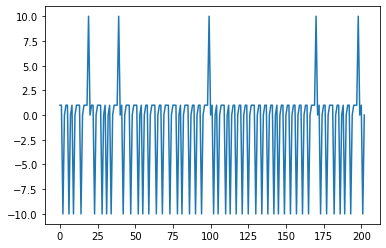

In [167]:
observers[0].plot();

In [168]:
def compute_avg_return(environment, policy, num_episodes=10):

    total_return = 0.0
    for _ in range(num_episodes):
        time_step = environment.reset()
        episode_return = 0.0

        while not time_step.is_last():
            action_step = policy.action(time_step)
            time_step = environment.step(action_step.action)
            episode_return += time_step.reward
        total_return += episode_return

    avg_return = total_return / num_episodes
    return avg_return.numpy()[0]

In [169]:
train_env.reset()
compute_avg_return(train_env,policy)

-8.2

# Entrainement
## Initialisation du premier historique

In [ ]:
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_capacity)

random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

observers = [replay_buffer.add_batch,MyObserver(verbose=False)]


collect_ope_driver = dynamic_step_driver.DynamicStepDriver(
  train_env,
  random_policy,
  observers=observers,
  num_steps=1000)

initial_time_step = train_env.reset()
collect_ope_driver.run(initial_time_step,maximum_iterations=num_iterations)


dataset = replay_buffer.as_dataset(
    sample_batch_size=4,
    num_steps=2)

iterator = iter(dataset)


In [ ]:
observers[1].plot();

In [ ]:
# # (Optional) Optimize by wrapping some of the code in a graph using 
# # TF function.
# agent.train = common.function(tf_agent.train)

# Reset the train step
agent.train_step_counter.assign(0)
eval_env.reset()
# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, agent.collect_policy,100)

print(avg_return)

returns = [avg_return]

In [ ]:
print(eval_env.envs[0]._logger)

In [179]:
time_step = None
policy_state = agent.collect_policy.get_initial_state(train_env.batch_size)
for _ in range(num_iterations):
    time_step, policy_state = collect_ope_driver.run(
      time_step=time_step,
      policy_state=policy_state,
      )

    # Sample a batch of data from the buffer and update the agent's network.
    experience, unused_info = next(iterator)
    train_loss = agent.train(experience).loss

    step =agent.train_step_counter.numpy()

    if step % log_interval == 0:
        print('step = {0}: loss = {1}'.format(step, train_loss))

    if step % eval_interval == 0:
        avg_return = compute_avg_return(eval_env, agent.collect_policy, \
                                        10)
        print('step = {0}: Average Return = {1}'.format(step, avg_return))
        returns.append(avg_return)

step = 100: loss = 141171552.0


/home/maxime/.pyenv/versions/iarchitect/lib/python3.8/site-packages/tf_agents/policies/tf_policy.py:252: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if policy_state is ():  # pylint: disable=literal-comparison
/home/maxime/.pyenv/versions/iarchitect/lib/python3.8/site-packages/tf_agents/policies/tf_policy.py:314: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if not (policy_state is None or policy_state is () or policy_state is []):  # pylint: disable=literal-comparison
/home/maxime/.pyenv/versions/iarchitect/lib/python3.8/site-packages/tf_agents/policies/tf_policy.py:252: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if policy_state is ():  # pylint: disable=literal-comparison
/home/maxime/.pyenv/versions/iarchitect/lib/python3.8/site-packages/tf_agents/policies/tf_policy.py:314: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if not (policy_state is None or policy_state is () or policy_state is []):  # pylint: disable=literal-comparison
/hom

KeyboardInterrupt: 

In [ ]:
observers = [MyObserver()]
driver = py_driver.PyDriver(
    environment, PyTFEagerPolicy(agent.policy), observers, max_steps=1000, max_episodes=5)

In [ ]:
time_spec_init = environment_eval.reset()
driver.run(time_spec_init)

In [ ]:
observers[-1].trajs